# Numerically minimising Pauli-weight

One frequently cited goal when designing an encoding $\mathcal{E}$ is to minimise the average number of Pauli-operators in the terms of the qubit Hamiltonian.

This can be done in a _Hamiltonian independent_ way, by considering the set of majorana operators $\set{\gamma}$. With $P(x)$ being the Pauli-weight of $x$,

$$P_{HI}(\mathcal{E}) = \frac{\sum_{\{\gamma\}}{P(\gamma_i)}}{|\set{\gamma}|}$$

If we have a specific Hamiltonian in mind, say the electronic structure hamiltonian, we can be more specific by finding the Pauli weight the set of Hamiltonian terms $\{h\}$ which result from encoding terms of the fermionic Hamiltonian ($a_i^{\dagger}a_j$ and $a_i^{\dagger}a_j^{\dagger}a_k a_l$). 

Note that we don't need to consider the Hamiltonian coefficents $\{\alpha_{i,j}, \alpha_{i,j,k,l}\}$ associated to each of those operators, so this Pauli-weight is _system independent_.

$$P_{HD}(\mathcal{E}, H_F) = \frac{\sum_{\set{h}}P(h)}{|\set{h}|}$$

When considering a real system (such as a water molecule), many of the terms of the fermionic Hamiltonian will represent transitions which are not allowed. As a result, some terms of the general qubit Hamiltonian will not be needed. 

This isn't the end of the story however, because the specific set of qubit operator terms which have non-zero coefficients depends on the enumeration scheme $f$ used in the encoding $\mathcal{E}_{f}$. Accounting for this, we have the _system dependent_ Pauli-weight:

$$P_{SD}(\mathcal{E}_{f}, H_F) = \frac{\sum_{h\in H_Q}P(h)}{|H_Q|}$$


First we'll import data we need specific to the water molecule.

In [1]:
import json
from ferrmion.encode import TernaryTree, MaxNTO
from pathlib import Path

def integrals():
    folder = Path.cwd().joinpath(Path("../../../python/tests/"))
    with open(folder.joinpath("./data/h2o_sto-3g.json"), 'rb') as file:
        data = json.load(file)
    return np.array(data["ones"]), np.array(data["twos"])

tree = TernaryTree(14)

## $P_{HI}$

In [2]:
from ferrmion import FermionQubitEncoding
import numpy as np
def hamiltonian_indpendent_weight(encoding: FermionQubitEncoding):
    _, symplectics = encoding._build_symplectic_matrix()
    x_block, z_block = np.hsplit(symplectics, 2)
    operator_weights = np.sum(np.bitwise_or(x_block, z_block),axis=1)
    return operator_weights

In [3]:
ham_indep = {"jw":None,"pe": None,"bk": None,"jkmn": None}
ham_indep["jw"]=hamiltonian_indpendent_weight(tree.JordanWigner())
ham_indep["pe"]=hamiltonian_indpendent_weight(tree.ParityEncoding())
ham_indep["bk"]=hamiltonian_indpendent_weight(tree.BravyiKitaev())
ham_indep["jkmn"]=hamiltonian_indpendent_weight(tree.JKMN())
ham_indep["MaxNTO"]=hamiltonian_indpendent_weight(MaxNTO(14))

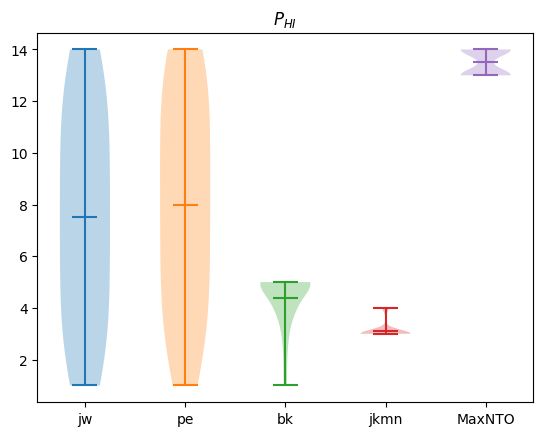

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots()
pos = 0
for dist in ham_indep.values():
    axs.violinplot(dist, [pos], showmeans=True)
    pos+=1

axs.set_xticks([*range(len(ham_indep))], labels=ham_indep.keys())
plt.title("$P_{HI}$")
plt.show()

So it seems there is a clear benefit to the multi-branch Bravyi-kitaev and JKMN (minimum height) trees!

Let's move on to see how these encodings behave when applied to the electronic structure Hamiltonian.

## $P_{HD}$

In [5]:
from ferrmion.optimize.enumeration import lambda_plus_mu
from ferrmion.optimize.cost_functions import coefficient_pauli_weight, pauli_weight
from ferrmion.hamiltonians import molecular_hamiltonian
import functools
ones, twos = integrals()

hamiltonians = {"jw":None,"pe": None,"bk": None,"jkmn": None}

fham = molecular_hamiltonian(ones, twos, physicist_notation=True)

hamiltonians["jw"] = tree.JW().encode(fham)
hamiltonians["pe"] = tree.ParityEncoding().encode(fham)
hamiltonians["bk"] = tree.BravyiKitaev().encode(fham)
hamiltonians["jkmn"] = tree.JKMN().encode(fham)
hamiltonians["MaxNTO"] = MaxNTO(14).encode(fham)


In [6]:
hamiltonians.keys()

dict_keys(['jw', 'pe', 'bk', 'jkmn', 'MaxNTO'])

In [7]:
import numpy as np
def template_pauli_weight(template):
    return [len(k) - k.count("I") for k in template.keys()]

ham_dep = {k: template_pauli_weight(v) for k,v in hamiltonians.items()}

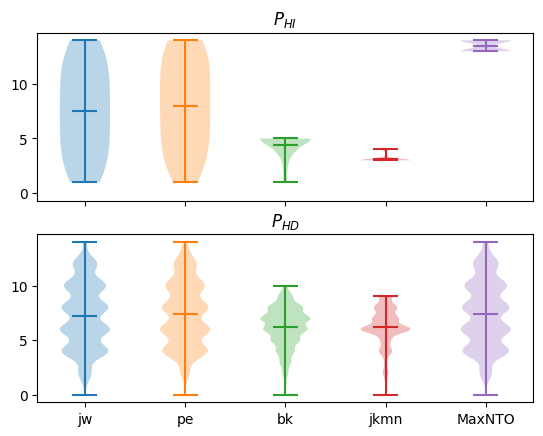

In [8]:
import matplotlib.pyplot as plt

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
pos = 0
for k in ham_dep.keys():
    axs[0].violinplot(ham_indep[k], [pos], showmeans=True)
    axs[1].violinplot(ham_dep[k], [pos], showmeans=True)
    pos+=1
axs[0].title.set_text("$P_{HI}$")
axs[1].title.set_text("$P_{HD}$")
axs[1].set_xticks([*range(len(ham_dep))], labels=ham_dep.keys())
plt.show()

How interesting! The Bravyi-Kitaev and JKMN encodings have lost their advantage now that we're considering the application of encodings to a Hamiltonian.

Conversely, the k-NTO encoding now performs much more similarly to the ternary trees. 

## $P_{SD}$

Let's start by finding $P_{SD}$ for a set of random permutations of the fermionic mode labels.

In [9]:
from ferrmion.core import encode

def find_permutation_norm(ipow, sym, fham, permutation):
    permutation = np.array(permutation, dtype=np.uint)
    mpermutation = np.array([2*permutation, 2*permutation+1]).T.flatten()
    sig, coeff = fham.signatures_and_coefficients
    ham = encode(ipowers=ipow[mpermutation], symplectics=sym[mpermutation], signatures=sig, coeffs=coeff, constant_energy=0.)
    return pauli_weight(ham)

As a test, lets check the naive enumeration, $(0,1,...,M) \to (0,1,...,M)$

In [10]:
from ferrmion.encode.ternary_tree import JordanWigner, BravyiKitaev, ParityEncoding, JKMN
naive = {}
for name, template in hamiltonians.items():
    perm = np.array([*range(14)], dtype=np.uint)
    match name:
        case "jw":
            encoding = JordanWigner(14)
        case "pe":
            encoding = ParityEncoding(14)
        case "bk":
            encoding = BravyiKitaev(14)
        case "jkmn":
            encoding = JKMN(14)
        case "MaxNTO":
            encoding = MaxNTO(14)
    ipow, sym = encoding._build_symplectic_matrix()
    naive[name] = find_permutation_norm(ipow, sym, fham, perm)[0]
naive

{'jw': np.int64(14749),
 'pe': np.int64(15040),
 'bk': np.int64(12662),
 'jkmn': np.int64(12707),
 'MaxNTO': np.int64(15069)}

Now we can run a set of random permutations.
 
Increasing the number of pemutations to try here will take longer but the plots later are more satisfying!

In [11]:
import numpy as np
from numpy.random import default_rng

def template_weight_distribution(name, n_perms): 
    rng = default_rng(seed=1017)
    weights = []
    match name:
        case "jw":
            encoding = JordanWigner(14)
        case "pe":
             encoding = ParityEncoding(14)
        case "bk":
            encoding = BravyiKitaev(14)
        case "jkmn":
            encoding = JKMN(14)
        case "MaxNTO":
            encoding = MaxNTO(14)
             
    for i in range(n_perms):
        ipow, sym = encoding._build_symplectic_matrix()
        if i ==0:
            perm = np.arange(14)
        else:
            perm = rng.permutation([*range(14)])
        weights.append(find_permutation_norm(ipow, sym, fham, perm)[0])
    return weights
    
distributions = {k: template_weight_distribution(k, 100) for k in ["jw", "pe", "bk", "jkmn", "MaxNTO"]}

Let's plot these, with the naive enumerations shown as dashed black lines.

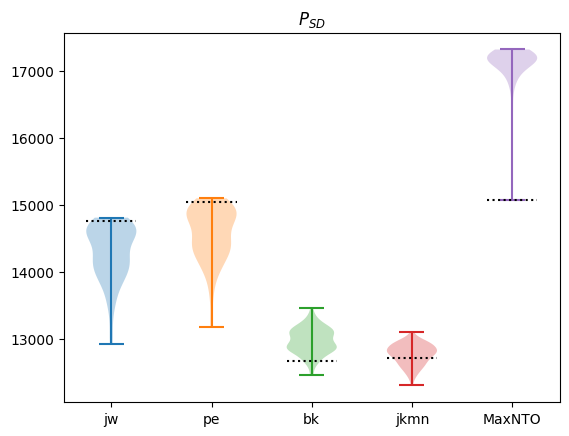

In [12]:
import matplotlib.pyplot as plt

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots()
pos = 0
for dist in distributions.values():
    axs.violinplot(dist, [pos])
    pos+=1
for pos, encoding in enumerate(naive):
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")
plt.title("$P_{SD}$")
axs.set_xticks([*range(len(distributions))], labels=distributions.keys())
plt.show()

Since k-NTO performs so much worse, let's remove it to look at the others more closely.

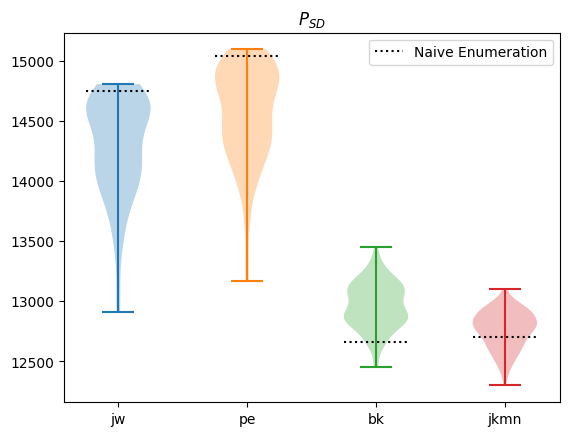

In [13]:
import matplotlib.pyplot as plt

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots()
pos = 0
for dist in [v for k,v in distributions.items() if k != "MaxNTO"]:
    axs.violinplot(dist, [pos])
    pos+=1
for pos, encoding in enumerate(naive):
    if encoding == "MaxNTO":
        continue
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")

naive_line = mlines.Line2D([], [], color='black', linestyle=":", label="Naive Enumeration")
axs.legend(handles=[naive_line])

    
plt.title("$P_{SD}$")
axs.set_xticks([*range(len(distributions)-1)], labels=[*distributions.keys()][:-1])
plt.show()

The naive enumeration seems to generally be one of the worst options for us here.

Let's try a numerical approach to optimise this.

## Simulated Annealing

Enumerations can also be optimised with simulated annealing. 

We just need to provide a temperature (using the number of modes tends to give good results) and an initial permutation.

In [ ]:
from ferrmion.optimize import anneal_enumerations

temp = fham.n_modes //2
annealed_best = {}
for name in hamiltonians.keys():
    print(name)
    sigs, coeffs = fham.signatures_and_coefficients
    match name:
        case "jw":
            encoding = JordanWigner(14)
        case "pe":
            encoding = ParityEncoding(14)
        case "bk":
            encoding = BravyiKitaev(14)
        case "jkmn":
            encoding = JKMN(14)
        case "MaxNTO":
            continue
    ipow, sym = encoding._build_symplectic_matrix()
    ipow, sym = anneal_enumerations(ipowers=ipow, symplectics=sym, signatures=sigs, coeffs=coeffs, temperature=temp, initial_guess=np.array([*range(14)], dtype=np.uint), coefficient_weighted=False)
    annealed_best[name] = find_permutation_norm(ipow, sym, fham, [*range(14)])

jw
pe
bk
jkmn
MaxNTO


In [20]:
annealed_best

{'jw': [np.int64(12154)],
 'pe': [np.int64(12939)],
 'bk': [np.int64(12067)],
 'jkmn': [np.int64(12126)],
 'MaxNTO': [np.int64(13534)]}

<>:19: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\ '
/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_36710/3556930878.py:19: SyntaxWarning: invalid escape sequence '\ '
  plt.title("$P_{SD}: H_{2}O\ STO-3G$")


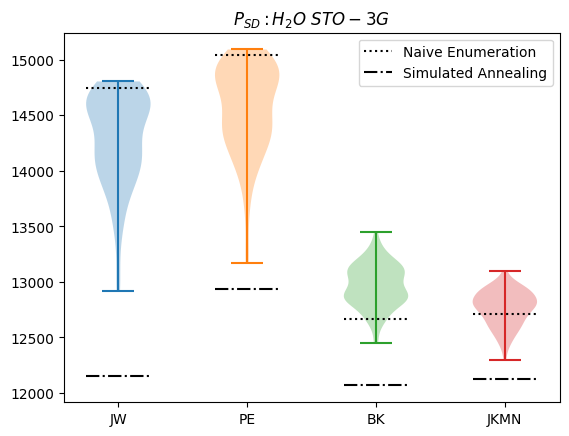

In [21]:
fig, axs = plt.subplots()
pos = 0
for encoding, dist in distributions.items():
    if encoding == "MaxNTO":
        continue
    axs.violinplot(dist, [pos])
    pos+=1
axs.set_xticks([*range(len(distributions)-1)], labels=["JW", "PE", "BK", "JKMN"])
for pos, encoding in enumerate(naive):
    if encoding == "MaxNTO":
        continue
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")
    axs.hlines(annealed_best[encoding][0],  pos-0.25, pos+0.25,  linestyles="-.", color="black")

naive_line = mlines.Line2D([], [], color='black', linestyle=":", label="Naive Enumeration")
anneal_line = mlines.Line2D([], [], color='black', linestyle="-.", label="Simulated Annealing")
axs.legend(handles=[naive_line, anneal_line])

plt.title("$P_{SD}: H_{2}O\ STO-3G$")
plt.show()

In [22]:
annealed_best

{'jw': [np.int64(12154)],
 'pe': [np.int64(12939)],
 'bk': [np.int64(12067)],
 'jkmn': [np.int64(12126)],
 'MaxNTO': [np.int64(13534)]}

## TOPP-HATT

In [23]:
from ferrmion.core import topphatt
temp = 14
topphatt_weight = {"MaxNTO": None}
for name in hamiltonians.keys():
    if name == "MaxNTO": 
        continue
    print(name)
    sigs, coeffs = fham.signatures_and_coefficients
    match name:
        case "jw":
            encoding = JordanWigner(14)
        case "pe":
            encoding = ParityEncoding(14)
        case "bk":
            encoding = BravyiKitaev(14)
        case "jkmn":
            encoding = JKMN(14)
    ipow, sym = encoding._build_symplectic_matrix()
    topphatt_weight[name] = pauli_weight(encoding.encode_topphatt(fham))

jw
pe
bk
jkmn


<>:21: SyntaxWarning: invalid escape sequence '\ '
<>:21: SyntaxWarning: invalid escape sequence '\ '
/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_36710/1850888455.py:21: SyntaxWarning: invalid escape sequence '\ '
  plt.title("$P_{SD}: H_{2}O\ STO-3G$")


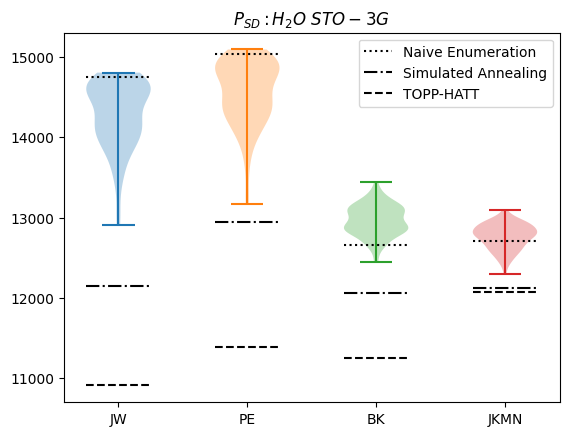

In [24]:
fig, axs = plt.subplots()
pos = 0
for encoding, dist in distributions.items():
    if encoding == "MaxNTO":
        continue
    axs.violinplot(dist, [pos])
    pos+=1
axs.set_xticks([*range(len(distributions)-1)], labels=["JW", "PE", "BK", "JKMN"])
for pos, encoding in enumerate(naive):
    if encoding == "MaxNTO":
        continue
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")
    axs.hlines(annealed_best[encoding][0],  pos-0.25, pos+0.25,  linestyles="-.", color="black")
    axs.hlines(topphatt_weight[encoding][0],  pos-0.25, pos+0.25,  linestyles="--", color="black")

naive_line = mlines.Line2D([], [], color='black', linestyle=":", label="Naive Enumeration")
anneal_line = mlines.Line2D([], [], color='black', linestyle="-.", label="Simulated Annealing")
topphatt_line = mlines.Line2D([], [], color='black', linestyle="--", label="TOPP-HATT")
axs.legend(handles=[naive_line, anneal_line, topphatt_line])

plt.title("$P_{SD}: H_{2}O\ STO-3G$")
plt.show()